# Load Data

In [1]:
# Load data from Kaggle - first upload credential kaggle.json file
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [2]:
# Download data from Kaggle
!pip install -q kaggle
!kaggle datasets download -d adityadesai13/used-car-dataset-ford-and-mercedes
# unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

  0% 0.00/1.10M [00:00<?, ?B/s]
100% 1.10M/1.10M [00:00<00:00, 35.5MB/s]
Archive:  used-car-dataset-ford-and-mercedes.zip
  inflating: audi.csv                
  inflating: bmw.csv                 
  inflating: cclass.csv              
  inflating: focus.csv               
  inflating: ford.csv                
  inflating: hyundi.csv              
  inflating: merc.csv                
  inflating: skoda.csv               
  inflating: toyota.csv              
  inflating: unclean cclass.csv      
  inflating: unclean focus.csv       
  inflating: vauxhall.csv            
  inflating: vw.csv                  


In [3]:
# List files to use in training data
files_to_concat = ['audi.csv','bmw.csv','cclass.csv','focus.csv', 'ford.csv', 'hyundi.csv',
                   'merc.csv', 'skoda.csv', 'toyota.csv', 'vauxhall.csv', 'vw.csv']

In [4]:
# Import libraries
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
import seaborn as sns
from string import ascii_letters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import pickle

In [5]:
# Read in data files
data_audi = pd.read_csv(files_to_concat[0])
data_bmw = pd.read_csv(files_to_concat[1])
data_cclass = pd.read_csv(files_to_concat[2])
data_focus = pd.read_csv(files_to_concat[3])
data_ford = pd.read_csv(files_to_concat[4])
data_hyundi = pd.read_csv(files_to_concat[5])
data_merc = pd.read_csv(files_to_concat[6])
data_skoda = pd.read_csv(files_to_concat[7])
data_toyota = pd.read_csv(files_to_concat[8])
data_vauxhall = pd.read_csv(files_to_concat[9])
data_vw = pd.read_csv(files_to_concat[10])

# Create manufacturer column
data_audi['make'] = 'Audi'
data_bmw['make'] = 'BMW'
data_cclass['make'] = 'C-Class'
data_focus['make'] = 'Focus'
data_ford['make'] = 'Ford'
data_hyundi['make'] = 'Hyundai'
data_merc['make'] = 'Mercedes'
data_skoda['make'] = 'Skoda'
data_toyota['make'] = 'Toyota'
data_vauxhall['make'] = 'Vauxhall'
data_vw['make'] = 'VW'

# Change column name for Hyundi
data_hyundi.rename({'tax(£)': 'tax'}, axis=1, inplace=True)

# Concat the files
data = pd.concat([data_audi,data_bmw,data_cclass,data_focus,data_ford,data_hyundi,data_merc,data_skoda,data_toyota,data_vauxhall,data_vw])

# EDA

In [6]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,Audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,Audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,Audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,Audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,Audi


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108540 entries, 0 to 15156
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           99187 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   make          108540 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 9.1+ MB


In [8]:
# Unique values for each categorical feature
cat_cols = ['model','transmission','fuelType','make']
num_cols = ['year', 'price','mileage','tax','mpg','engineSize']
for col in cat_cols:
  print(col, ':', len(data[col].unique()))

model : 195
transmission : 4
fuelType : 5
make : 11


In [9]:
# Percent of missing values for each column
data.isnull().sum() * 100 / len(data) 

model           0.0000
year            0.0000
price           0.0000
transmission    0.0000
mileage         0.0000
fuelType        0.0000
tax             8.6171
mpg             8.6171
engineSize      0.0000
make            0.0000
dtype: float64

In [10]:
# Impute tax, mpg using the other features
num_cols = ['mpg','tax']
data_nums = data[num_cols]
imputer_nums = IterativeImputer(ExtraTreesRegressor(n_estimators=10, random_state=0))
impute_data = imputer_nums.fit_transform(data_nums)
data[num_cols] = impute_data

In [11]:
# Percent of missing values for each column
data.isnull().sum() * 100 / len(data) 

model           0.0
year            0.0
price           0.0
transmission    0.0
mileage         0.0
fuelType        0.0
tax             0.0
mpg             0.0
engineSize      0.0
make            0.0
dtype: float64

In [12]:
# Check for duplicate rows
duplicate_rows_df = data[data.duplicated()]
print('Number of duplicated rows: ', duplicate_rows_df.shape[0])
# Drop duplicated rows
data = data.drop_duplicates()
duplicate_rows_df = data[data.duplicated()]
print('Number of duplicated rows: ', duplicate_rows_df.shape[0])

Number of duplicated rows:  2273
Number of duplicated rows:  0


In [13]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,106267.000000,106267.000000,106267.000000,106267.000000,106267.000000,106267.000000
mean,2017.072497,16863.020787,23219.477919,115.912314,55.419984,1.664939
std,2.132114,9780.077771,21126.685272,62.412800,15.533540,0.558165
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10190.000000,7724.000000,67.597770,47.100000,1.200000
50%,2017.000000,14578.000000,17515.000000,145.000000,56.500000,1.600000
75%,2019.000000,20882.000000,32449.000000,145.000000,61.400000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


[2017 2016 2019 2015 2014 2018 2013 2020 2004 2009 2012 2010 2007 2011
 2008 2003 2005 2002 2006 1998 1997 2001 2000 1999 1996 1991 1995 2060
 1970]


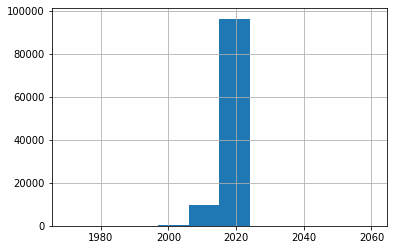

In [14]:
# Year seems off - into the future - explore further
data['year'].hist()
print(data['year'].unique())

In [15]:
# Remove row with year = 2060
data = data[data['year'] != 2060]

[2017 2016 2019 2015 2014 2018 2013 2020 2004 2009 2012 2010 2007 2011
 2008 2003 2005 2002 2006 1998 1997 2001 2000 1999 1996 1991 1995 1970]


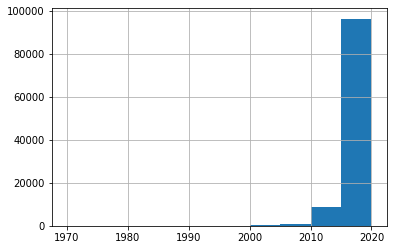

In [16]:
# Better!
data['year'].hist()
print(data['year'].unique())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd9689bc88>,
      dtype=object)

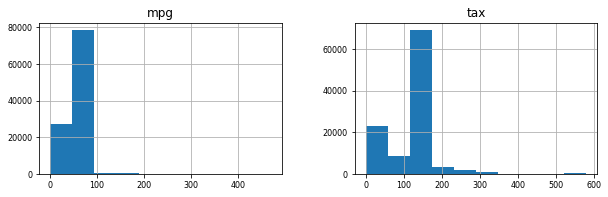

In [17]:
# Histograms for numerical variables
data[num_cols].hist(figsize=(10,10), layout=(3, 2), xlabelsize=8, ylabelsize=8)

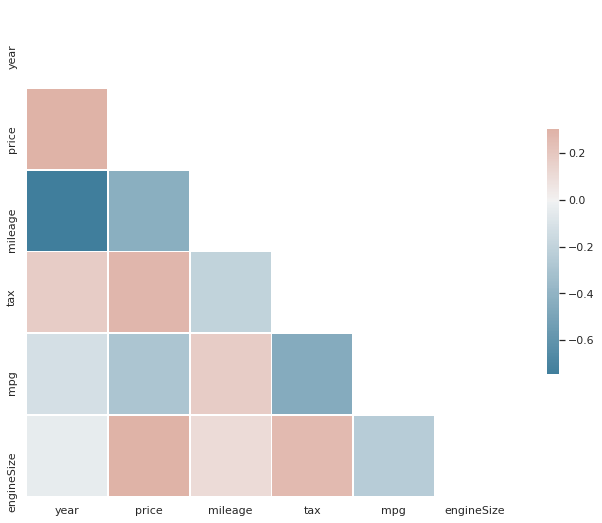

In [18]:
# Heatmap to check correlation
sns.set_theme(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

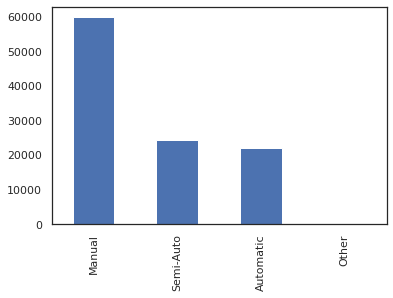

In [19]:
# Bar plots for categorical variables
data[cat_cols[1]].value_counts().plot(kind='bar')

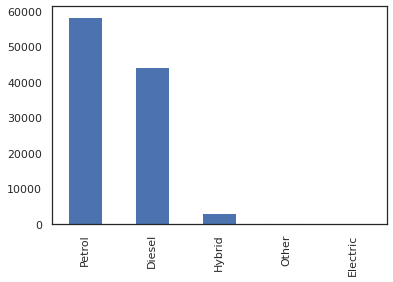

In [20]:
data[cat_cols[2]].value_counts().plot(kind='bar')

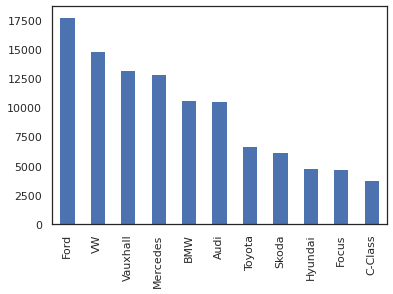

In [21]:
data[cat_cols[3]].value_counts().plot(kind='bar')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

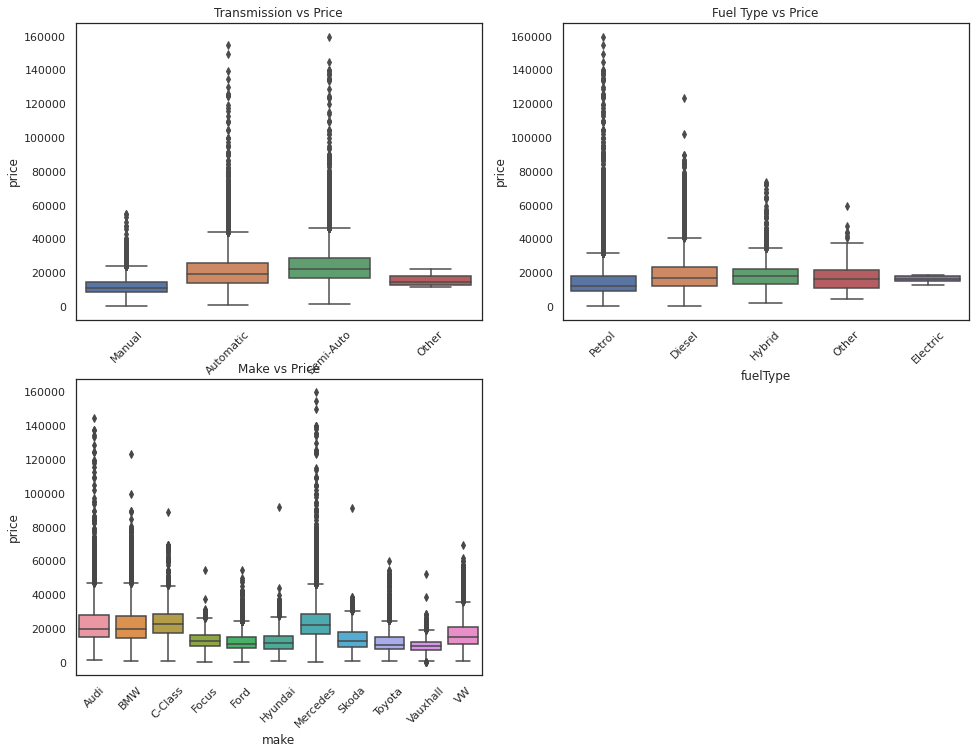

In [22]:
# Boxplots for categorical variables
plt.figure(figsize=(16, 12))
plt.subplot(221)
sns.boxplot(x = 'transmission', y=data['price'], data = data)
plt.title('Transmission vs Price')
plt.xticks(rotation=45)
plt.subplot(222)
sns.boxplot(x = 'fuelType', y=data['price'], data = data)
plt.title('Fuel Type vs Price')
plt.xticks(rotation=45)
plt.subplot(223)
sns.boxplot(x = 'make', y=data['price'], data = data)
plt.title('Make vs Price')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

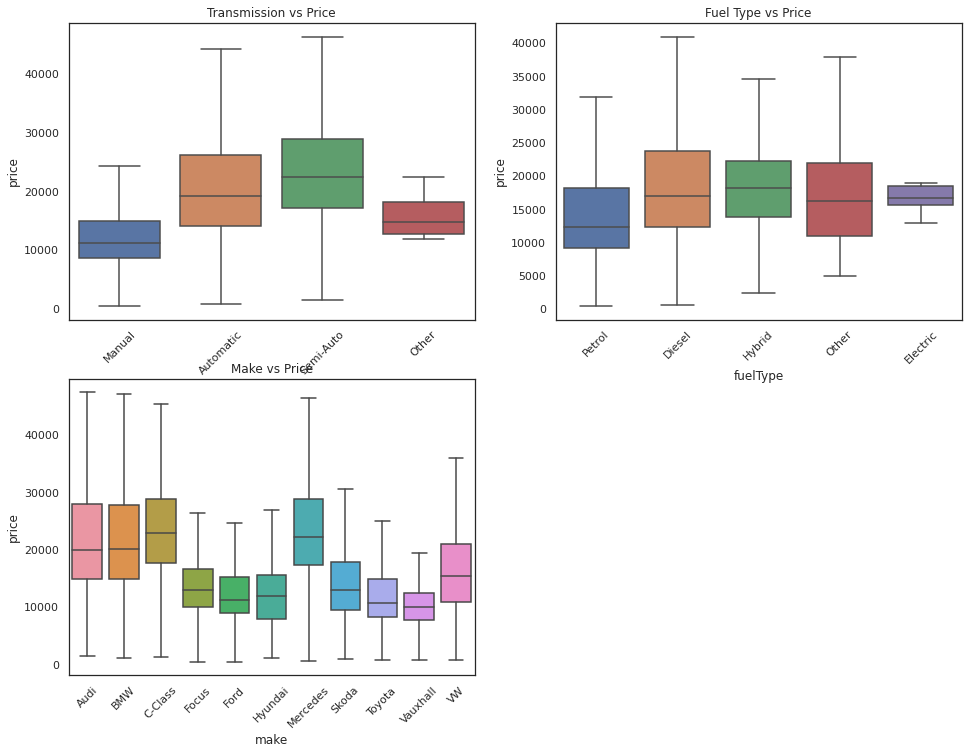

In [23]:
# Boxplots for categorical variables - without outliers
plt.figure(figsize=(16, 12))
plt.subplot(221)
sns.boxplot(x = 'transmission', y=data['price'], data = data, showfliers=False)
plt.title('Transmission vs Price')
plt.xticks(rotation=45)
plt.subplot(222)
sns.boxplot(x = 'fuelType', y=data['price'], data = data, showfliers=False)
plt.title('Fuel Type vs Price')
plt.xticks(rotation=45)
plt.subplot(223)
sns.boxplot(x = 'make', y=data['price'], data = data, showfliers=False)
plt.title('Make vs Price')
plt.xticks(rotation=45)

Most cars available for sale in different price ranges

In [24]:
# We can use 5 different price ranges:
# Bucket 1: < 5000
# Bucket 2: 5000 - 10000
# Bucket 3: 10000 - 15000
# Bucket 4: 15000 - 20000
# Bucket 5: > 20000

bucket_1 =  data[data['price'] < 5000].groupby('model')['model'].count().sort_values(ascending=False).index[0]
bucket_2 = data[(data['price'] >= 5000) & (data['price'] < 10000)].groupby('model')['model'].count().sort_values(ascending=False).index[0]
bucket_3 = data[(data['price'] >= 10000) & (data['price'] < 15000)].groupby('model')['model'].count().sort_values(ascending=False).index[0]
bucket_4 = data[(data['price'] >= 15000) & (data['price'] < 20000)].groupby('model')['model'].count().sort_values(ascending=False).index[0]
bucket_5 =  data[data['price'] > 20000].groupby('model')['model'].count().sort_values(ascending=False).index[0]

print(bucket_1)
print(bucket_2)
print(bucket_3)
print(bucket_4)
print(bucket_5)

 Corsa
 Fiesta
 Focus
 Focus
 C Class


Which makes depreciate the least / most?

In [25]:
print(data[['make','price','mileage']].groupby('make').corr().iloc[0::2,-1].sort_values())
print(data[['make','price','year']].groupby('make').corr().iloc[0::2,-1].sort_values())

make           
Focus     price   -0.738737
C-Class   price   -0.675564
BMW       price   -0.605473
Vauxhall  price   -0.598983
Mercedes  price   -0.537272
Audi      price   -0.534739
Ford      price   -0.530501
VW        price   -0.519119
Skoda     price   -0.481398
Hyundai   price   -0.443754
Toyota    price   -0.300598
Name: mileage, dtype: float64
make           
Toyota    price    0.422813
Mercedes  price    0.519482
Hyundai   price    0.575325
Audi      price    0.592196
Skoda     price    0.606975
VW        price    0.617975
BMW       price    0.623754
Ford      price    0.645221
C-Class   price    0.670687
Vauxhall  price    0.700659
Focus     price    0.763545
Name: year, dtype: float64


# Model Development

In [ ]:
# Encode data - one-hot encoding for categorical variables
data_encoded = pd.get_dummies(data)
data_encoded.columns = data_encoded.columns.str.replace(' ', '')
data_encoded.rename({'model_B-MAX':'model_B_MAX',
                    'model_C-HR':'model_C_HR',
                    'model_C-MAX':'model_C_MAX',
                    'model_GrandC-MAX':'model_GrandC_MAX',
                    'model_Ka+':'model_Ka_plus',
                    'model_S-MAX':'model_S_MAX',
                    'model_T-Cross':'model_T_Cross',
                    'model_T-Roc':'model_T_Roc',
                    'model_Verso-S':'model_Verso_S',
                    'model_X-CLASS':'model_X_CLASS',
                    'transmission_Semi-Auto':'transmission_Semi_Auto',
                    'make_C-Class':'make_C_Class'}, axis=1, inplace=True)

In [ ]:
data_encoded.head()

,year,price,mileage,tax,mpg,engineSize,model_1Series,model_2Series,model_3Series,model_4Series,model_5Series,model_6Series,model_7Series,model_8Series,model_AClass,model_A1,model_A2,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_Accent,model_Adam,model_Agila,model_Amarok,model_Amica,model_Ampera,model_Antara,model_Arteon,model_Astra,model_Auris,model_Avensis,model_Aygo,model_BClass,model_B_MAX,model_Beetle,model_CClass,model_C_HR,...,model_X1,model_X2,model_X3,model_X4,model_X5,model_X6,model_X7,model_Yaris,model_Yeti,model_YetiOutdoor,model_Z3,model_Z4,model_Zafira,model_ZafiraTourer,model_i3,model_i8,model_180,model_200,model_220,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi_Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,make_Audi,make_BMW,make_C_Class,make_Focus,make_Ford,make_Hyundai,make_Mercedes,make_Skoda,make_Toyota,make_VW,make_Vauxhall
0,2017,12500,15735,150.0,55.4,1.4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,2016,16500,36203,20.0,64.2,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2016,11000,29946,30.0,55.4,1.4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,2017,16800,25952,145.0,67.3,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2019,17300,1998,145.0,49.6,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_encoded.shape

(106266, 221)

In [ ]:
# Output clean data file to csv
# data_encoded.to_csv('UKUsedCarPrics.csv', index=False)

## Test different models with default parameters

In [ ]:
# Split data into train / test with 80/20 split
X = data_encoded.drop(['price'], axis=1)
y = data_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))
print(math.sqrt(mean_squared_error(y_train, reg.predict(X_train))))
print(math.sqrt(mean_squared_error(y_test, reg.predict(X_test))))
# pickle.dump(reg, open('lin_reg_model.pkl', "wb"))

0.8560492845140886
0.8645605103257259
3695.6760726437346
3656.6525184976845


## XGBoost

In [ ]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,y_train)

train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)

[16:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(math.sqrt(mean_squared_error(y_train, train_preds)))
print(math.sqrt(mean_squared_error(y_test, test_preds)))

3085.4867729693556
3093.1359254886547


In [ ]:
from xgboost import XGBRegressor

# grid search
model = XGBRegressor()

param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'min_child_weight': np.arange(0.0001, 0.5, 0.001),
        'gamma': np.arange(0.0,40.0,0.005),
        'learning_rate': np.arange(0.0005,0.3,0.0005),
        'subsample': np.arange(0.01,1.0,0.01),
        'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
        'colsample_bytree': np.arange(0.1,1.0,0.01)
}

kfold = KFold(n_splits=10, shuffle=True, random_state=10)
grid_search = RandomizedSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", n_iter = 100, cv=kfold)
grid_result = grid_search.fit(X_train,y_train)

[16:04:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:06:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:08:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

Best: -1901.549003 using {'subsample': 0.61, 'min_child_weight': 0.4031, 'max_depth': 12, 'learning_rate': 0.166, 'gamma': 10.395, 'colsample_bytree': 0.8699999999999996, 'colsample_bylevel': 1.0}


In [ ]:
params={'subsample': 0.61, 'min_child_weight': 0.4031, 'max_depth': 12, 'learning_rate': 0.166, 'gamma': 10.395, 'colsample_bytree': 0.8699999999999996, 'colsample_bylevel': 1.0}
xgb_model = xgb.XGBRegressor(params=params)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train,y_train, eval_set=eval_set)

file_name = "xgb_reg.pkl"

# save
# pickle.dump(xgb_model, open(file_name, "wb"))

[18:19:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:17692.6	validation_1-rmse:17821.1
[1]	validation_0-rmse:16110	validation_1-rmse:16235.3
[2]	validation_0-rmse:14674	validation_1-rmse:14795.3
[3]	validation_0-rmse:13419.1	validation_1-rmse:13548.7
[4]	validation_0-rmse:12270	validation_1-rmse:12400.2
[5]	validation_0-rmse:11274.1	validation_1-rmse:11409.8
[6]	validation_0-rmse:10361.1	validation_1-rmse:10496.8
[7]	validation_0-rmse:9550.83	validation_1-rmse:9685.51
[8]	validation_0-rmse:8852.28	validation_1-rmse:8995.84
[9]	validation_0-rmse:8214.72	validation_1-rmse:8360.98
[10]	validation_0-rmse:7644.02	validation_1-rmse:7785.48
[11]	validation_0-rmse:7164.22	validation_1-rmse:7311.17
[12]	validation_0-rmse:6721.66	validation_1-rmse:6875.23
[13]	validation_0-rmse:6336.59	validation_1-rmse:6489.36
[14]	validation_0-rmse:6013.23	validation_1-rmse:6166.75
[15]	validation_0-rmse:5714.47	val

In [ ]:
results = xgb_model.evals_result()
print(results)

{'validation_0': {'rmse': [17692.617188, 16110.03125, 14673.984375, 13419.097656, 12270.029297, 11274.104492, 10361.112305, 9550.825195, 8852.283203, 8214.722656, 7644.022461, 7164.221191, 6721.659668, 6336.587891, 6013.225586, 5714.474121, 5457.025879, 5234.423828, 5037.106934, 4861.366699, 4715.305176, 4584.398438, 4465.606934, 4359.871094, 4273.417969, 4190.781738, 4112.633301, 4045.945801, 3990.762451, 3938.337891, 3896.045898, 3850.856934, 3807.437012, 3771.740723, 3743.262451, 3708.247559, 3681.69873, 3658.864258, 3632.050293, 3614.489258, 3595.546387, 3580.504395, 3559.919189, 3540.642334, 3525.999268, 3510.980957, 3498.61084, 3486.809082, 3468.65625, 3453.165283, 3442.697266, 3432.560059, 3418.20752, 3402.510986, 3391.750488, 3379.098633, 3370.490234, 3361.246094, 3349.506104, 3340.121338, 3331.954834, 3324.355713, 3316.740234, 3306.447266, 3299.694336, 3292.429688, 3283.273193, 3276.673096, 3268.138428, 3261.840332, 3254.088623, 3247.776367, 3240.154053, 3232.352783, 3226.2341

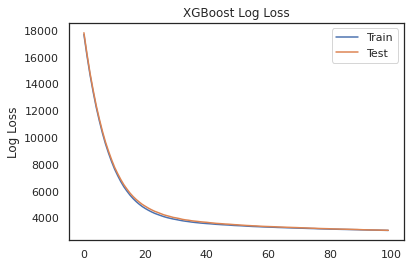

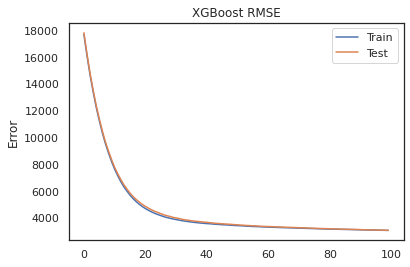

In [ ]:
from matplotlib import pyplot

# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('Error')
pyplot.title('XGBoost RMSE')
pyplot.show()

# Model Goodness of Fit

In [ ]:
# Load model
file_name = "xgb_reg.pkl"
xgb_model = pickle.load(open(file_name, "rb"))

[21:23:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
train_predictions = xgb_model.predict(X_train)
test_predictions = xgb_model.predict(X_test)

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

# MAE
train_mae = np.sqrt(mean_absolute_error(y_train, train_predictions))
test_mae = np.sqrt(mean_absolute_error(y_test, test_predictions))
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)

Train RMSE:  3085.4867729693556
Test RMSE:  3093.1359254886547
Train MAE:  45.80306742140816
Test MAE:  46.053815005853295


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


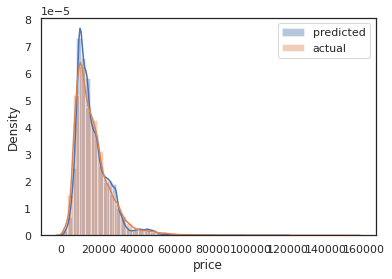

In [ ]:
# Distribution plots - Training data
sns.distplot(train_predictions, label='predicted')
sns.distplot(y_train, label='actual')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


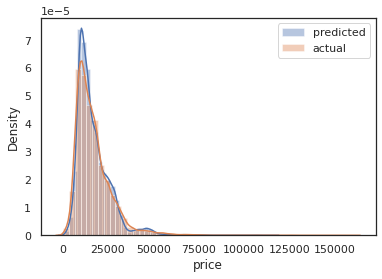

In [ ]:
# Distribution plots - Test data
sns.distplot(test_predictions, label='predicted')
sns.distplot(y_test, label='actual')
plt.legend()
plt.show()

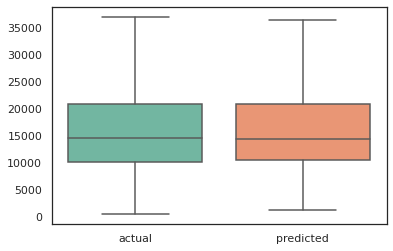

In [ ]:
# Boxplots - Training data
train = {'actual': y_train, 'predicted': train_predictions}
train_df = pd.DataFrame(train)
sns.boxplot(data=train_df, palette='Set2', showfliers=False)

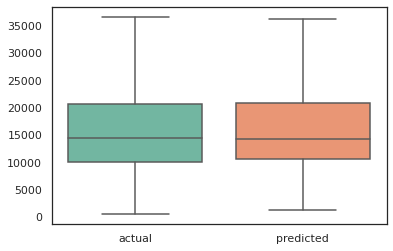

In [ ]:
# Boxplots - Test data
test = {'actual': y_test, 'predicted': test_predictions}
test_df = pd.DataFrame(test)
sns.boxplot(data=test_df, palette='Set2', showfliers=False)

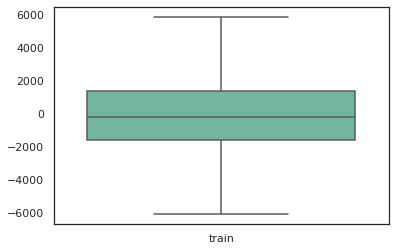

In [ ]:
# Boxplots - Train residuals
train_resid = y_train - train_predictions
resid = {'train': train_resid}
resid_df = pd.DataFrame(data=resid)
sns.boxplot(data=resid_df, palette='Set2', showfliers=False)

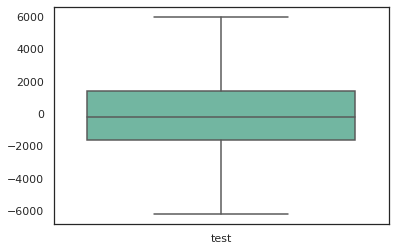

In [ ]:
# Boxplots - Test residuals
test_resid = y_test - test_predictions
resid = {'test': test_resid}
resid_df = pd.DataFrame(data=resid)
sns.boxplot(data=resid_df, palette='Set2', showfliers=False)

Look at how the features impact the target via SHAP values

In [ ]:
#!pip install shap
import shap

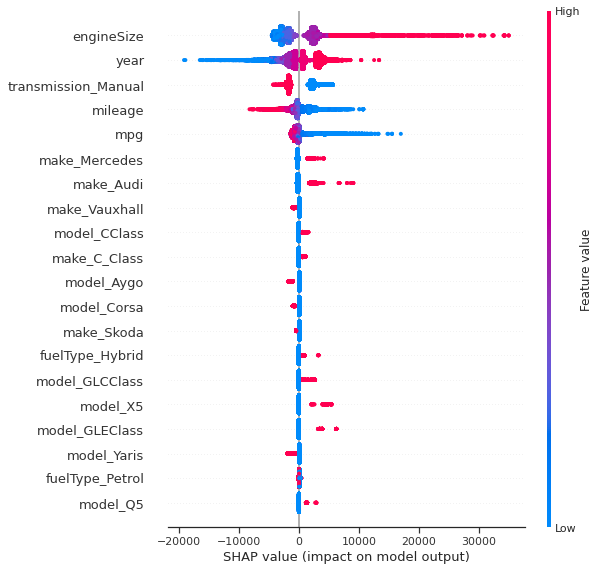

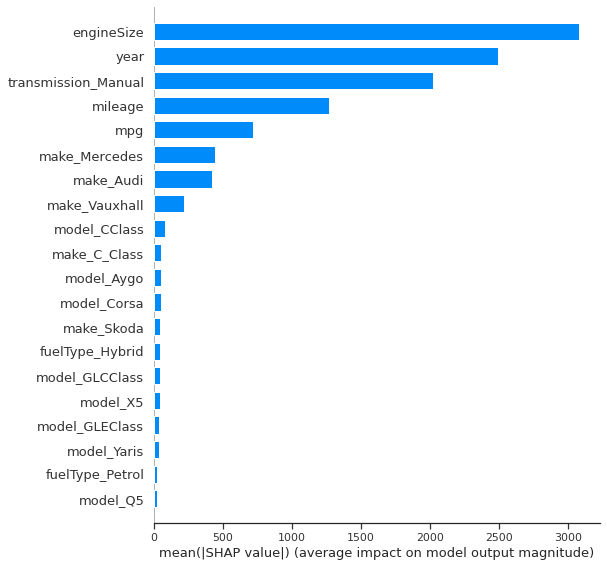

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values_train = explainer.shap_values(X_train)
shap.summary_plot(shap_values_train, X_train)
shap.summary_plot(shap_values_train, X_train, plot_type='bar')